Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict species using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
from palmerpenguins import load_penguins
import pandas as pd

penguins = load_penguins()

penguins = penguins.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [10]:
import numpy as np
import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_fscore_support
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_classic, ggtitle

# Set up target and predictor variables
y = penguins["species"]
X = penguins.drop(columns= ["species"])

# create ct to dummify and standardize
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)
# Split data with stratification (for classification)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline_KNN3 = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsClassifier(n_neighbors=3))
])
pipeline_kNN7 = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsClassifier(n_neighbors=7))
])
pipeline_tree5 = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', DecisionTreeClassifier(max_depth=5, random_state=42))
])
pipeline_tree10 = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', DecisionTreeClassifier(max_depth=10, random_state=42))
])

# List of models
models = [pipeline_KNN3, pipeline_kNN7, pipeline_tree5, pipeline_tree10]
model_names = ["kNN (k=3)", "kNN (k=7)", "Decision Tree (depth=5)", "Decision Tree (depth=10)"]

# Evaluate each model
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Confusion Matrix
    print(f"\n{name} - Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Overall Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy:.2f}")

    # Precision, Recall, F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=model.classes_)
    print(f"{name} - Precision, Recall, F1 for each species:")
    for i, species in enumerate(model.classes_):
        print(f"  {species} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1: {f1[i]:.2f}")

    # AUC (one-vs-all approach)
    y_pred_proba = model.predict_proba(X_test)
    auc_scores = {}
    for i, species in enumerate(model.classes_):
        auc_scores[species] = float(roc_auc_score((y_test == species).astype(int), y_pred_proba[:, i]))
    print(f"{name} - AUC for each species:", auc_scores)


kNN (k=3) - Confusion Matrix:
[[36  1  0]
 [ 1 16  0]
 [ 0  0 30]]
kNN (k=3) - Accuracy: 0.98
kNN (k=3) - Precision, Recall, F1 for each species:
  Adelie - Precision: 0.97, Recall: 0.97, F1: 0.97
  Chinstrap - Precision: 0.94, Recall: 0.94, F1: 0.94
  Gentoo - Precision: 1.00, Recall: 1.00, F1: 1.00
kNN (k=3) - AUC for each species: {'Adelie': 0.9994249568717654, 'Chinstrap': 0.9991220368744512, 'Gentoo': 1.0}

kNN (k=7) - Confusion Matrix:
[[37  0  0]
 [ 0 17  0]
 [ 0  0 30]]
kNN (k=7) - Accuracy: 1.00
kNN (k=7) - Precision, Recall, F1 for each species:
  Adelie - Precision: 1.00, Recall: 1.00, F1: 1.00
  Chinstrap - Precision: 1.00, Recall: 1.00, F1: 1.00
  Gentoo - Precision: 1.00, Recall: 1.00, F1: 1.00
kNN (k=7) - AUC for each species: {'Adelie': 1.0, 'Chinstrap': 1.0, 'Gentoo': 1.0}

Decision Tree (depth=5) - Confusion Matrix:
[[37  0  0]
 [ 0 17  0]
 [ 2  0 28]]
Decision Tree (depth=5) - Accuracy: 0.98
Decision Tree (depth=5) - Precision, Recall, F1 for each species:
  Adelie 

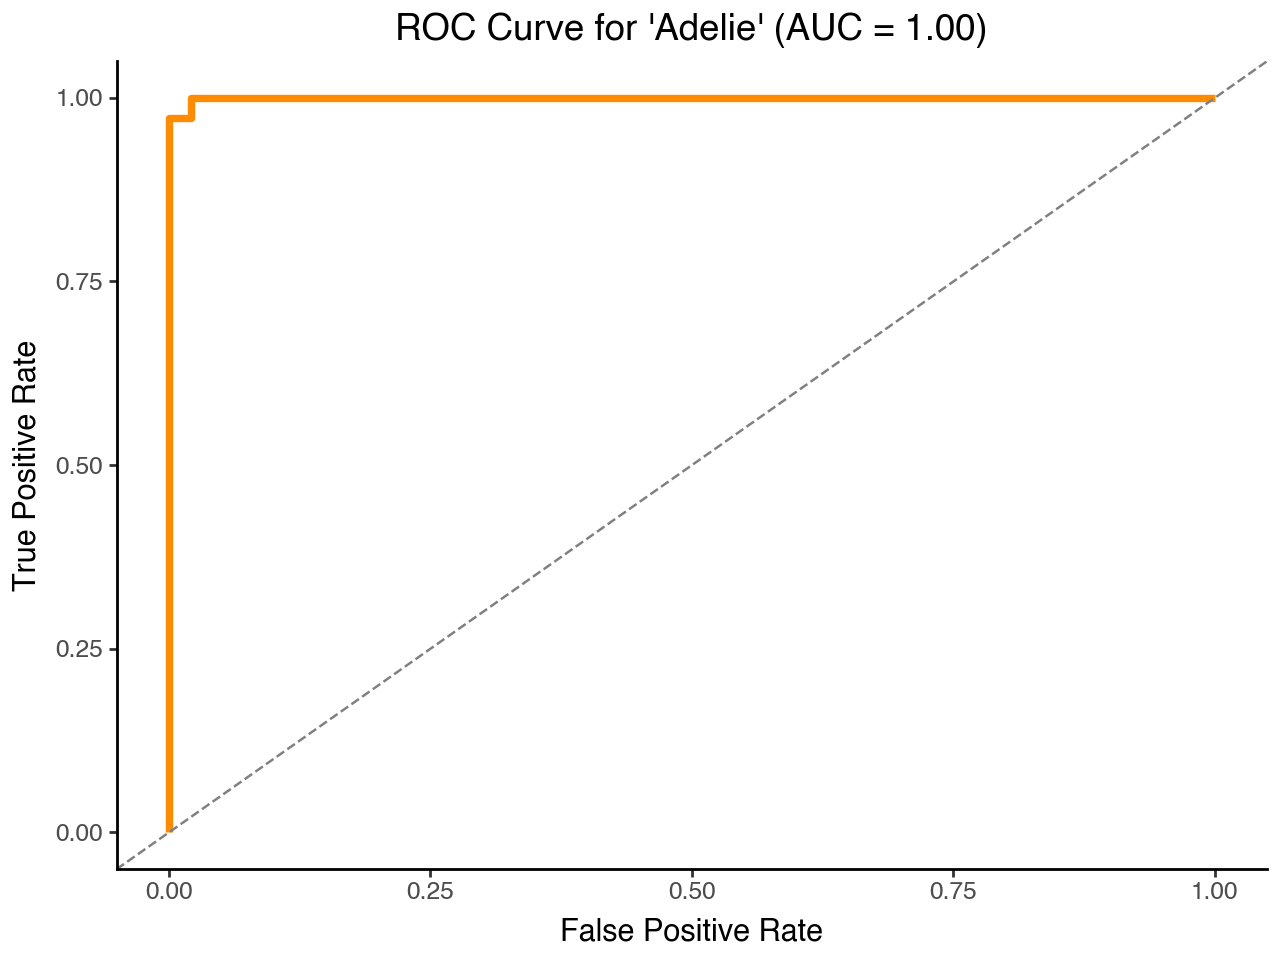

In [12]:
pipeline_KNN3.fit(X_train, y_train)

# Generate predictions and ROC data for a selected species (e.g., 'Adelie')
selected_species = "Adelie"
y_pred_proba = pipeline_KNN3.predict_proba(X_test)
species_index = list(pipeline_KNN3.classes_).index(selected_species)
fpr, tpr, _ = roc_curve((y_test == selected_species).astype(int), y_pred_proba[:, species_index])
roc_auc = auc(fpr, tpr)

# Prepare data for ggplot-style ROC curve
roc_data = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

# Plot with plotnine (ggplot-style)
roc_plot = (
    ggplot(roc_data, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='darkorange', size=1.5) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='grey') +
    labs(title=f"ROC Curve for '{selected_species}' (AUC = {roc_auc:.2f})",
         x="False Positive Rate",
         y="True Positive Rate") +
    theme_classic()
)

roc_plot.show()